# Plot model predictions for equilibrium fraction in range expansions experiments

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))
sns.set_theme(style="white", palette="deep")
sns.set_palette("deep")

from scipy.stats import t

## Load Data

In [19]:
#load dictionary with fit parameters from file
with open('Processed-datafiles/fit_parameters.txt', 'r') as file:
    fit_pars = eval(file.read())

#load dictionary with growth rates from file    
with open('Experimental-datafiles/growth_rates.txt', 'r') as file:
    growth_rates = eval(file.read())
    
#we replace WT growth rate with average growth rate of dP and dT in presence of AA, as this is our actual control condition
growth_rates['WT'] = (growth_rates['dP'] + growth_rates['dT'])/2   
    
#load dataframe with preprocessing results
df_in = pd.read_csv('Processed-datafiles/community_data_mean.csv')  
  
#select data eq. values
df_data = pd.DataFrame({"community": df_in["Condition"],
                        '$\Delta$proC frequency': 1 - df_in["Ratio"], #dProC frequency = 1 - dTrpC frequency
                        '$\Delta$proC frequency SE': df_in["Ratio_std"] / np.sqrt(df_in['N_eq']), # add standard error
                        "source": "Data"})

#drop AA condition
df_data = df_data[df_data['community'] != 'AA'].reset_index(drop=True)

#rename community names to match paper
community_names = { 'A' : 'Ctr',
                    'B' : 'Pu',    #Pu: increased uptake of P
                    'C' : 'Tp',    #Tp: increased production of T
                    'D' : 'Tp Pu',  #Tp Pu: increased production of T and uptake of P
                    'E' : 'Pp',    #Pp: increased production of P
                    'F' : 'Pp Pu',  #Pp Pu: increased production of P and uptake of P
                    'G' : 'Tp Pp',  #Tp Pp: increased production of T and P
                    'H' : 'Tp Pp Pu' #Tp Pp Pu: increased production of T and P and uptake of P
                    }
df_data['community'] = df_data['community'].replace(community_names)
df_data.head(n=8)

,community,$\Delta$proC frequency,$\Delta$proC frequency SE,source
0,Ctr,0.759394,0.006690,Data
1,Pu,0.610443,0.011432,Data
2,Tp,0.442632,0.009008,Data
3,Tp Pu,0.427640,0.002335,Data
4,Pp,0.838174,0.019978,Data
5,Pp Pu,0.699493,0.015892,Data
6,Tp Pp,0.665429,0.030864,Data
7,Tp Pp Pu,0.691584,0.023284,Data


---

## Predict community properties

As we do not know the precise increase in Proline uptake rate, we thus estimate Eq. frequencies assuming a 10, 50, or 100-fold increase.

In [20]:
df_list = [df_data]

#loop over the different values of proline uptake fold increase
Pu_fold_increase = np.array([10, 50, 100])

for pu in Pu_fold_increase:
    
    #specify the parameters for the different communities
    par_com_A = { #Ctr: original community
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': 1,
                'c_up_P': 1,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_B = { #Pu: increased uptake of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': 1,
                'c_up_P': pu,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_proUp'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_C = { #Tp: increased production of T
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': fit_pars['c_prod_T'], 
                'c_prod_P': 1,
                'c_up_P': 1,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_trpOP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_D = { # Tp Pu: increased production of T and uptake of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': fit_pars['c_prod_T'], 
                'c_prod_P': 1,
                'c_up_P': pu,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_proUp_trpOP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_E = { #Pp: increased production of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': fit_pars['c_prod_P'],
                'c_up_P': 1,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP'],
                'mu_dT': growth_rates['dT_proOP'],
                }

    par_com_F = { #Pp Pu: increased production of P and uptake of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': fit_pars['c_prod_P'],
                'c_up_P': pu,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_proUp'], 
                'mu_dT': growth_rates['dT_proOP'],
                }


    par_com_G = { #Tp Pp: increased production of T and P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': fit_pars['c_prod_T'], 
                'c_prod_P': fit_pars['c_prod_P'],
                'c_up_P': 1,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_trpOP'],
                'mu_dT': growth_rates['dT_proOP'],
                }

    par_com_H = { #Tp Pp Pu: increased production of T and P and uptake of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': fit_pars['c_prod_T'], 
                'c_prod_P': fit_pars['c_prod_P'],
                'c_up_P': pu,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_proUp_trpOP'], 
                'mu_dT': growth_rates['dT_proOP'],
                }

    #create a dictionary with the parameters for the different communities
    par_coms = {'Ctr': par_com_A, #Ctr: original community
                'Pu': par_com_B, #Pu: increased uptake of P
                'Tp': par_com_C, #Tp: increased production of T
                'Tp Pu': par_com_D, #Tp Pu: increased production of T and uptake of P
                'Pp': par_com_E, #Pp: increased production of P
                'Pp Pu': par_com_F, #Pp Pu: increased production of P and uptake of P
                'Tp Pp': par_com_G, #Tp Pp: increased production of T and P
                'Tp Pp Pu': par_com_H} #Tp Pp Pu: increased production of T and P and uptake of P   

    #run the community model for the different communities
    communities = {key: community(**val) for key, val in par_coms.items()}

    #extract the equilibrium properties of the different communities
    df_pred = pd.DataFrame({"community": df_data["community"],
                            "source": f"Model {pu}-fold increase Pro uptake"}) 
    for key, val in communities.items():
        df_pred.loc[df_pred["community"]==key, "$\Delta$proC frequency"] = 1-val.eq

    df_list.append(df_pred)

df = pd.concat(df_list, ignore_index=True)
df.to_csv('Processed-datafiles/predictions_eqfrequency.csv', index=False)

In [21]:
# Calculate the change in frequency for the different communities relative to the control
for source in df['source'].unique():
    df_loc = df[df['source'] == source]
    ctrl = df_loc[df_loc['community'] == 'Ctr']['$\Delta$proC frequency'].values[0]
    ctrl_SE = df_loc[df_loc['community'] == 'Ctr']['$\Delta$proC frequency SE'].values[0]
    
    #calculate change in frequency    
    df.loc[df['source'] == source, 'Change in $\Delta$proC frequency'] = df_loc['$\Delta$proC frequency'] - ctrl
    #calc SE for the change, change = (X_i_data - X_ctr_data) so SE = sqrt(SE_data^2 + SE_ctr_data^2) 
    df.loc[df['source'] == source, 'Change in $\Delta$proC frequency SE'] = np.sqrt(df_loc['$\Delta$proC frequency SE']**2 + ctrl_SE**2)    

## Plot comparison of model predictions and data

### Plot predictions EQ frequency

In [22]:
def make_bar_plot(df, xname, yname, errname, huename, ax):
    """
    Create a bar plot using the provided data.

    Parameters:
    - df: DataFrame containing the data.
    - xname: Name of the column in df representing the x-axis values.
    - yname: Name of the column in df representing the y-axis values.
    - errname: Name of the column in df representing the error values.
    - huename: Name of the column in df representing the hue values.
    - ax: Axes object to plot the bar plot on.

    Returns:
    None
    """
    hues = df[huename].unique()
    xvals = df[xname].unique()

    x = np.arange(len(xvals))  # the label locations
    width = (1 - 0.1*len(hues))/len(hues)   # the width of the bars
        
    if len(hues) == 1:
        offset_vec = [0]
    elif len(hues) == 2:
        offset_vec = [-width/2, width/2]
    else: 
        offset_vec = np.linspace(-1,1,len(hues))*0.3 if len(hues) >1 else [0]

    for idx, hue in enumerate(hues):
        y = df[df[huename] == hue][yname].to_numpy()
        err = df[df[huename] == hue][errname].to_numpy()
        ax.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(x)
    ax.set_xticklabels(xvals)

    ax.set_ylabel(yname)
    ax.tick_params(axis='x', rotation=45)

    return None

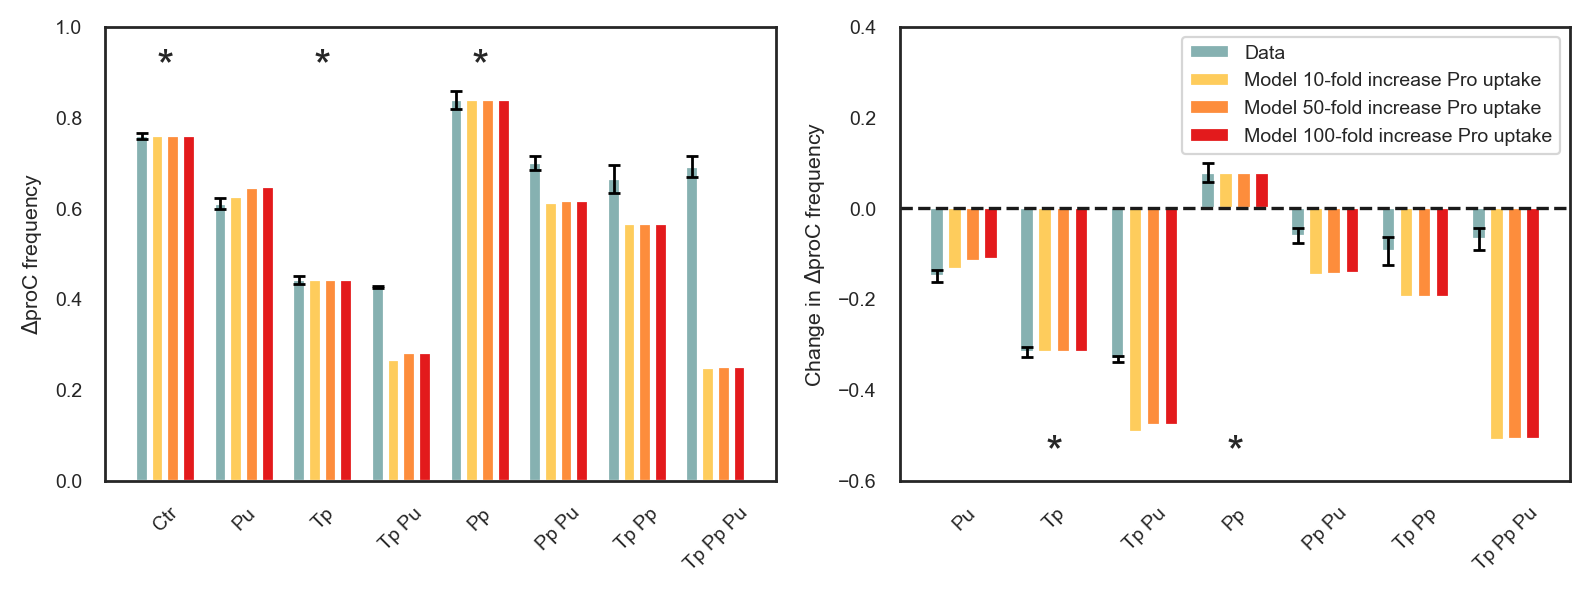

In [30]:
# Apply seaborn style
sns.set_theme(style="white", palette="deep")

# Set the context with smaller font scale
sns.set_context("paper", font_scale=0.8)

col = np.array([
    [134, 177, 177],
    [254,204,92],
    [253,141,60],
    [227,26,28]
]) / 255
sns.set_palette(sns.color_palette(col))

#plot the prediction and data for EQ freq and relative range
fig, axs = plt.subplots(1,2,figsize=(8,3))
make_bar_plot(df, "community", "$\Delta$proC frequency", "$\Delta$proC frequency SE", "source", axs[0])
axs[0].set_ylim(top=1)  # Set max y-axis value for each subplot
#axs[0].legend(loc='upper right')
fig.tight_layout()


df_sub = df[df["community"] != "Ctr"].reset_index(drop=True)
make_bar_plot(df_sub, "community", "Change in $\Delta$proC frequency", "Change in $\Delta$proC frequency SE", "source", axs[1])
axs[1].set_ylim(bottom=-0.6, top=0.4)  # Set max y-axis value for each subplot
axs[1].legend(loc='upper right')
fig.tight_layout()

# Add stars above communities that where fitted to the data
y_star_eq = 0.02
ssize = 16
dsize = 10
axs[0].annotate('*', xy=(0, 0.95), fontsize=ssize, ha='center', va='top')
axs[0].annotate('*', xy=(2, 0.95), fontsize=ssize, ha='center', va='top')
axs[0].annotate('*', xy=(4, 0.95), fontsize=ssize, ha='center', va='top')

axs[1].annotate('*', xy=(1, -0.5), fontsize=ssize, ha='center', va='top')
axs[1].annotate('*', xy=(3, -0.5), fontsize=ssize, ha='center', va='top')

axs[1].axhline(y=0, color='k', linestyle='--')


fig.savefig(f"Figures/model_predictions_eqfrac_all_uptake.pdf")
plt.show()

### Plot Eq Fraction 50x fold increase Pro Uptake

We see that the precise value of the increase in Pro uptake does not strongly affect the EQ. frequency, we thus plot the results assuming a 50x increase.

In [24]:
df_50x = pd.concat([df[df["source"] == "Data"], df[df["source"] == "Model 50-fold increase Pro uptake"]], ignore_index=True)
df_50x["source"] = df_50x["source"].replace("Model 50-fold increase Pro uptake", "Model")

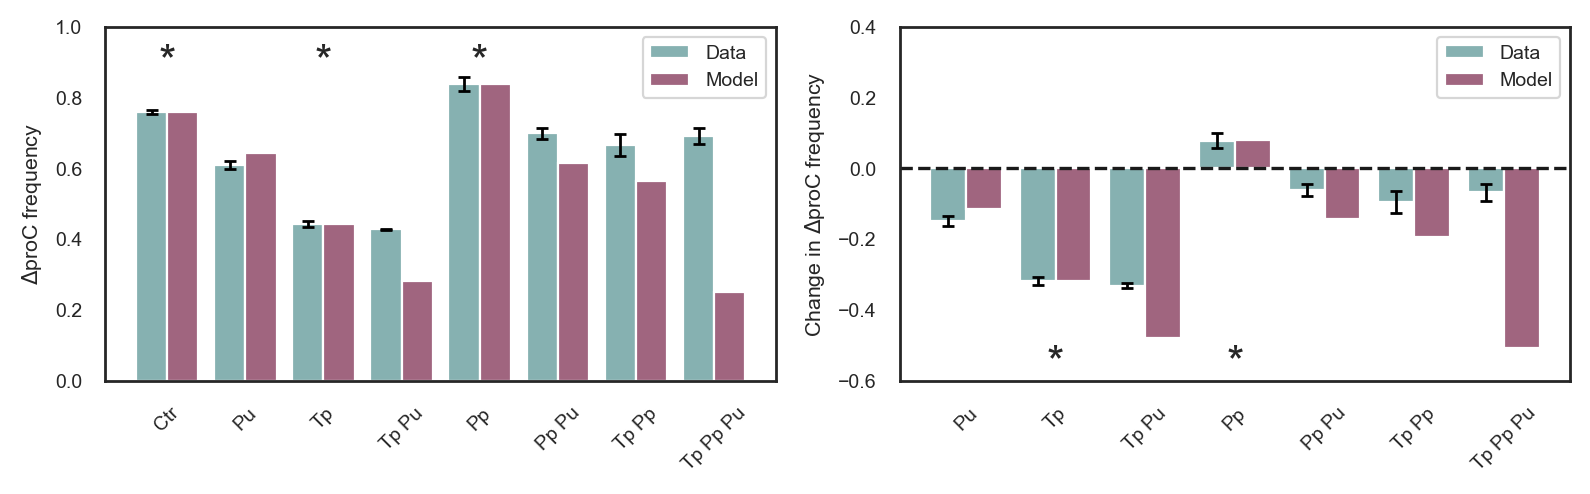

In [28]:
#plot the prediction and data for EQ freq and relative range
col = np.array([[134, 177, 177], [160, 101, 127]]) / 255
sns.set_palette(sns.color_palette(col))
fig, axs = plt.subplots(1,2,figsize=(8,2.5))
make_bar_plot(df_50x, "community", "$\Delta$proC frequency", "$\Delta$proC frequency SE", "source", axs[0])
fig.tight_layout()

# Set max y-axis value for each subplot
axs[0].set_ylim(top=1)  # Set max y-axis value for the first subplot

axs[0].legend(loc='upper right')

df_sub = df_50x[df_50x["community"] != "Ctr"].reset_index(drop=True)
make_bar_plot(df_sub, "community", "Change in $\Delta$proC frequency", "Change in $\Delta$proC frequency SE", "source", axs[1])
axs[1].set_ylim(bottom=-0.6, top=0.4)  # Set max y-axis value for each subplot
axs[1].legend(loc='upper right')
fig.tight_layout()

# Add stars above communities that where fitted to the data
y_star_eq = 0.02
ssize = 16
dsize = 10
axs[0].annotate('*', xy=(0, 0.95), fontsize=ssize, ha='center', va='top')
axs[0].annotate('*', xy=(2, 0.95), fontsize=ssize, ha='center', va='top')
axs[0].annotate('*', xy=(4, 0.95), fontsize=ssize, ha='center', va='top')

axs[1].annotate('*', xy=(1, -0.5), fontsize=ssize, ha='center', va='top')
axs[1].annotate('*', xy=(3, -0.5), fontsize=ssize, ha='center', va='top')

axs[1].axhline(y=0, color='k', linestyle='--')

fig.savefig(f"Figures/model_predictions_eqfrac_50x_uptake_increase.pdf")
plt.show()